In [129]:
import sys
sys.path.append('..')

import h5py
from proSVD import proSVD
import numpy as np
import matplotlib.pyplot as plt
import pdb
from utils.utils import *
from models.data_manager import DataManager
from models.mice_data_loader import MiceDataLoader

In [130]:
processed_dir = '/home/sachinks/Data/processed/mouse-cshl'

data_ld = MiceDataLoader(None, processed_dir)

###
mouse_id = 'mSM49'
date = '14-Sep-2018'
cam = '2'

data_ld.init_file(mouse_id, date, cam)

raw_dir: None
processed_dir: /home/sachinks/Data/processed/mouse-cshl
verbose: True
raw_dir: None
processed_dir: /home/sachinks/Data/processed/mouse-cshl
verbose: True
mouse_id: mSM49
date: 14-Sep-2018
cam: 2
processed_filename: mSM49_14-Sep-2018_cam2


In [131]:
video = cv2.VideoCapture(data_ld.get_videofilepath())
fps = video.get(cv2.CAP_PROP_FPS)

In [132]:
PROSVD_K = 4 # no. of dims to reduce to
PROSVD_INIT_FRAME = 100 # No of initial frames used to initialize proSVD

video_metadata = {
    'shape': None,
    'fps': fps
}

In [133]:
##################################
def compute_prosvd():
    generator = stream_video(data_ld.get_videofilepath())

    frames = []  # for proSVD initialization

    # Iterate over the generator and process each batch
    for index, frame in enumerate(generator):
        frame = rgb_to_grayscale(frame)

        if index > 500:
            break

        if index == 0:
            video_metadata['shape'] = frame.shape

        frame = frame.flatten()

        if index < PROSVD_INIT_FRAME:
            frames.append(frame)
            continue

        if index == PROSVD_INIT_FRAME:
            frames = np.array(frames).T
            pro = proSVD(k=PROSVD_K, w_len=1,history=0, decay_alpha=1, trueSVD=True)
            pro.initialize(frames)

        pro.preupdate()
        pro.updateSVD(frame[:, None])
        pro.postupdate()

        dm.add('Q', pro.Q)
        dm.add('S', pro.S)
        ld = pro.Q.T@frame # loadings
        dm.add('ld', ld)
    dm.to_numpy()
##################################

dm = DataManager()
compute_prosvd()

Saving proSVD outputs

In [134]:
output_dir = '/home/sachinks/Data/output/mouse-cshl'
output_dir = f'{output_dir}/{data_ld.get_filename()}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

dm.save(output_dir)

Visualization of proSVD

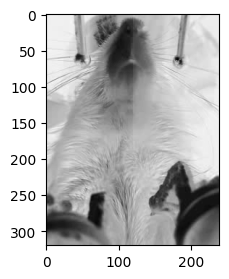

In [135]:
Q = dm.get('Q')
frame_shape = video_metadata['shape']
i = 0
Qi = Q[i]
Qi = Qi.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
plt.figure(figsize=(3, 3))
plt.imshow(Qi[..., 0], cmap='gray')
plt.show()

In [136]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from itertools import islice


# Q = dm.get('Q')
# frame_shape = video_metadata['shape']

# # Create a figure with a 2x2 grid of subplots
# fig, axs = plt.subplots(2, 2)

# fps = video_metadata['fps']

# # Initialize empty plots for the first frames
# images = []

# Q0 = Q[0]
# Q0 = Q0.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
# for i in range(4):
#     ax = axs[i // 2, i % 2]
#     im = ax.imshow(Q0[..., i], cmap='gray')
#     images.append(im)
#     ax.set_title(f"Basis {i+1}")  # Add titles to each subplot
#     ax.axis('off')

# # Super-title for the whole figure
# suptitle = plt.suptitle('', fontsize=16, y=0.98)  # Initial frame number

# # Function to update the plots with each new frame
# def update(frame_idx):
#     Qi = Q[frame_idx]
#     Qi = Qi.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
#     for j in range(4):
#         images[j].set_array(Qi[..., j])
#     suptitle.set_text(f'Time: {(frame_idx+PROSVD_INIT_FRAME)//fps}s')
#     return images

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(Q), interval=100, repeat=False)

# # Save the animation as a GIF (optional)
# ani.save('animation_mice.gif', writer='pillow', fps=fps)

# # Show the animation (displaying it in Jupyter Notebook or an interactive environment)
# plt.show()